In [1]:
import pandas as pd
import numpy as np

import os

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor as LGB
from catboost import CatBoostRegressor as CB

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler

from src.nn_tabular_models.saint_model import SAINTModel
from src.nn_tabular_models.tabpfn_model import TABPFNModel
from src.nn_tabular_models.tab_transformer_model import TabTransformerModel
from src.nn_tabular_models.autoint_model import AutoIntModel
from src.nn_tabular_models.ft_transformer_model import FTTransformerModel
from pytorch_tabnet.tab_model import TabNetRegressor

from src.abalone_dataset import AbaloneDataset

from sklearn.metrics import mean_squared_log_error, mean_squared_error

import torch
from torch.utils.data import DataLoader

import functools
rmse = functools.partial(mean_squared_error, squared=False)
rmsle = functools.partial(mean_squared_log_error, squared=False)

SEED=42

from src.styles import set_styles, TXT_ACC, TXT_RESET

import warnings
warnings.filterwarnings('ignore')



# ---- REPRODICIBILITY ------------------------------------------------
np.random.seed(SEED)



# ---- PANDAS ---------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.4f}'.format



set_styles()

In [2]:
class CFG:
    path_train = 'data/train.csv'
    path_test = 'data/test.csv'
    path_original = 'data/abalone.csv'
    target = 'Rings'

In [3]:
mapper_sex = {'I':0, 'F':1, 'M':2}

df_train = pd.read_csv(CFG.path_train).drop('id', axis=1)
df_train['Sex'] = df_train['Sex'].map(mapper_sex)

df_test = pd.read_csv(CFG.path_test).drop('id', axis=1)
df_test['Sex'] = df_test['Sex'].map(mapper_sex)

df_original = pd.read_csv(CFG.path_original)
df_original['Sex'] = df_original['Sex'].map(mapper_sex)
df_original = df_original.rename(columns={'Shucked weight': 'Whole weight.1', 'Viscera weight': 'Whole weight.2'})

# Get NN predictions on fold 0

In [4]:
def OH_transform(df_input):
    df = df_input.copy()
    for val in sorted(df['Sex'].unique()):
        df[f'Sex_{val}'] = (df['Sex'] == val).astype(int)
    df = df.drop('Sex', axis=1)
    return df

def label_transform(df_input):
    df = df_input.copy()
    mapper_sex = {'I':0, 'F':1, 'M':2}
    df['Sex'] = df['Sex'].map(mapper_sex)
    return df


def preproc_data(df_input, scaler=None, df_original=None):
    df = OH_transform(df_input)

    if scaler is None:
        scaler = StandardScaler()
        data = scaler.fit_transform(df.drop(CFG.target, axis=1))
        target = np.log1p(df[CFG.target]).values
        return data, target, scaler
    else:
        return scaler.transform(df)

In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
cv_idx = [idx for idx in cv.split(df_train, df_train[CFG.target])]

df_train = pd.read_csv(CFG.path_train).drop('id', axis=1)
data, target, _ = preproc_data(df_train)

train_data = data[cv_idx[0][0]]
train_target = target[cv_idx[0][0]]
val_data = data[cv_idx[0][1]]
val_target = target[cv_idx[0][1]]

dataset_train = AbaloneDataset(train_data, train_target)
dataset_val = AbaloneDataset(val_data, val_target)

batch_size=2**5
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

In [6]:
experiments = (
                ('saint_8_1', SAINTModel, {'in_features': 10, 'hidden_dim': 8, 'num_attention_heads': 8, 'num_layers': 1, 'dropout': 0.2}),
                ('saint_8_2', SAINTModel, {'in_features': 10, 'hidden_dim': 8, 'num_attention_heads': 8, 'num_layers': 2, 'dropout': 0.2}),
                ('saint_8_4', SAINTModel, {'in_features': 10, 'hidden_dim': 8, 'num_attention_heads': 8, 'num_layers': 4, 'dropout': 0.2}),
                ('saint_40_1', SAINTModel, {'in_features': 10, 'hidden_dim': 40, 'num_attention_heads': 8, 'num_layers': 1, 'dropout': 0.2}),
                ('saint_40_2', SAINTModel, {'in_features': 10, 'hidden_dim': 40, 'num_attention_heads': 8, 'num_layers': 2, 'dropout': 0.2}),

                ('tabpfn_16_32', TABPFNModel, {'in_features': 10, 'hidden_dim_list': [16, 32], 'dropout': 0.2}),
                ('tabpfn_8_8_8', TABPFNModel, {'in_features': 10, 'hidden_dim_list': [8, 8, 8], 'dropout': 0.2}),
                ('tabpfn_64_64', TABPFNModel, {'in_features': 10, 'hidden_dim_list': [64, 64], 'dropout': 0.2}),

                ('tab_8_1', TabTransformerModel, {'in_features': 10, 'hidden_dim': 8, 'num_attention_heads': 8, 'num_layers': 1, 'dropout': 0.2}),
                ('tab_8_2', TabTransformerModel, {'in_features': 10, 'hidden_dim': 8, 'num_attention_heads': 8, 'num_layers': 2, 'dropout': 0.2}),
                ('tab_8_4', TabTransformerModel, {'in_features': 10, 'hidden_dim': 8, 'num_attention_heads': 8, 'num_layers': 4, 'dropout': 0.2}),
                ('tab_40_1', TabTransformerModel, {'in_features': 10, 'hidden_dim': 40, 'num_attention_heads': 8, 'num_layers': 1, 'dropout': 0.2}),
                ('tab_40_2', TabTransformerModel, {'in_features': 10, 'hidden_dim': 40, 'num_attention_heads': 8, 'num_layers': 2, 'dropout': 0.2}),
                
                ('autoint_20_2_with_original', AutoIntModel, {'in_features': 10, 'embedding_dim': 20, 'num_heads': 20, 'num_layers': 2, 'dropout': 0.2,}),
                ('autoint_20_4_with_original', AutoIntModel, {'in_features': 10, 'embedding_dim': 20, 'num_heads': 20, 'num_layers': 4, 'dropout': 0.2,}),
                ('autoint_40_2_with_original', AutoIntModel, {'in_features': 10, 'embedding_dim': 40, 'num_heads': 40, 'num_layers': 2, 'dropout': 0.2,}),
                
                ('ft_8_4_with_original', FTTransformerModel, {'in_features': 10, 'hidden_dim': 8, 'num_attention_heads': 8, 'num_layers': 4, 'dropout': 0.2}),
                ('ft_8_8_with_original', FTTransformerModel, {'in_features': 10, 'hidden_dim': 8, 'num_attention_heads': 8, 'num_layers': 8, 'dropout': 0.2}),
                ('ft_16_4_with_original', FTTransformerModel, {'in_features': 10, 'hidden_dim': 16, 'num_attention_heads': 16, 'num_layers': 4, 'dropout': 0.2}),

               )

directory = 'nn_models_fold0_data_OH'
df_nn_preds = pd.DataFrame(index=cv_idx[0][1])
for label, model_class, model_params in experiments:
    model = model_class(**model_params)
    model.load_state_dict(torch.load(f'{directory}/{label}.pth'))
    model.eval()

    preds = []
    model.eval()
    with torch.no_grad():
        for batch in loader_val:
            out = model(batch[0])
            preds.extend(out.cpu().numpy())

    df_nn_preds[label] = np.expm1(preds)

# df_nn_preds.to_csv('nn_preds_fold0.csv')

# Get tree model predictions on fold 0

In [7]:
params_cb = {
    'depth': 5,
    'iterations': 983,
    'l2_leaf_reg': 21.078,
    'learning_rate': 0.1942,
    'loss_function': 'RMSE',
    'min_data_in_leaf': 136, 
    'subsample': 0.8,
    'random_state':      SEED,
    'verbose': 0,
}

params_lgb_tuned = {'learning_rate': 0.09989,
         'max_depth':5,
         'n_estimators':680,
         'reg_alpha': 1.751,
         'reg_lambda': 22.574,
         'subsample': 0.5,
         'random_state': SEED,
         'verbose': -1,}

params_lgb_orig = {  'learning_rate': 0.1454,
                'max_depth':     5,
                'n_estimators':  579,
                'reg_alpha':     0.9231,
                'reg_lambda':    99.217,
                'subsample':     1,
                'random_state':  SEED,
                'verbose':       -1,}

params_cb_orig = {
    'depth': 6,
    'iterations': 989,
    'l2_leaf_reg': 49.471,
    'learning_rate': 0.1892,
    'loss_function': 'RMSE',
    'min_data_in_leaf': 169, 
    'subsample': 0.5,
    'random_state':      SEED,
    'verbose': 0,
} 

params_cb_fold0 = {'depth': 7, 'verbose': 0, 'subsample': 0.7999999999999999, 'iterations': 974, 'l2_leaf_reg': 20.62778627087155, 'random_state': 42, 'learning_rate': 0.1444264894797429, 'loss_function': 'RMSE', 'min_data_in_leaf': 103}
params_lgb_fold0 = {'device': 'cpu', 'boosting': 'gbdt', 'max_depth': 5, 'objective': 'regression', 'reg_alpha': 2.790271401831723, 'subsample': 0.8999999999999999, 'reg_lambda': 98.86202121297616, 'n_estimators': 640, 'random_state': 42, 'learning_rate': 0.1765129798011447}

models = (
            ('catboost', TransformedTargetRegressor(
                            CB(**params_cb),
                            func=np.log1p, 
                            inverse_func=np.expm1)),
            ('lgb', TransformedTargetRegressor(
                            LGB(**params_lgb_tuned, num_leaves=2**params_lgb_tuned['max_depth']-1), 
                            func=np.log1p, 
                            inverse_func=np.expm1)),
            ('catboost_with_orig', TransformedTargetRegressor(
                            CB(**params_cb_fold0),
                            func=np.log1p, 
                            inverse_func=np.expm1)),
            ('lgb_with_orig', TransformedTargetRegressor(
                            LGB(**params_lgb_fold0, num_leaves=2**params_lgb_fold0['max_depth']-1), 
                            func=np.log1p, 
                            inverse_func=np.expm1)),
         )

X = df_train.drop(CFG.target, axis=1)
X['Sex'] = X['Sex'].map(mapper_sex)
Y = df_train[CFG.target]
X_orig = df_original.copy()
Y_orig = X_orig.pop(CFG.target)
preds_tree_models = []
for label, model in models:
    if 'with_orig' in label:
        model.fit(  pd.concat([X.loc[cv_idx[0][0]], X_orig], axis=0),  
                    pd.concat([Y.loc[cv_idx[0][0]], Y_orig], axis=0))
    else:
        model.fit(X.loc[cv_idx[0][0]], Y.loc[cv_idx[0][0]])
    preds_tree_models.append( model.predict(X.loc[cv_idx[0][1]]) )

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


In [8]:
df_ag = pd.read_csv('oof_Autogluon_with_original.csv').loc[cv_idx[0][1]]
df_preds = df_nn_preds.copy()
df_preds['autogluon'] = df_ag['Rings_oof']
df_preds[['catboost', 'lgb', 'cb_orig', 'lgb_orig']] = np.array(preds_tree_models).T
df_preds

,saint_8_1,saint_8_2,saint_8_4,saint_40_1,saint_40_2,tabpfn_16_32,tabpfn_8_8_8,tabpfn_64_64,tab_8_1,tab_8_2,tab_8_4,tab_40_1,tab_40_2,autoint_20_2_with_original,autoint_20_4_with_original,autoint_40_2_with_original,ft_8_4_with_original,ft_8_8_with_original,ft_16_4_with_original,autogluon,catboost,lgb,cb_orig,lgb_orig
2,4.0345,4.0114,4.2181,3.9659,3.8416,4.8639,5.6590,5.0513,4.5489,4.1319,4.3128,4.0851,3.9244,4.4032,4.6616,4.4042,3.9160,4.0568,4.1766,3.9029,3.9554,3.9791,3.8441,3.9400
3,10.0354,10.0910,10.0554,9.8232,9.7590,9.7980,9.5723,10.1151,9.9507,10.0093,10.1087,10.4722,9.7598,10.1727,10.1170,10.2058,9.9324,9.9529,9.9874,10.1516,10.0409,9.9845,10.1224,9.9860
5,10.1574,10.2969,9.9627,9.9654,10.0524,10.0304,9.2441,9.9027,10.2789,9.9984,10.1305,10.5670,9.6298,10.0354,10.1610,9.9077,9.8832,9.8960,10.1640,9.9553,9.6870,9.9058,10.0472,9.5895
6,8.3621,8.5879,8.6520,8.0684,8.3081,8.8338,8.6750,8.6720,8.7285,8.6938,8.7533,8.3446,8.5931,8.4620,8.7148,8.5534,8.6970,8.2454,8.4672,9.7040,9.6714,9.3659,9.4777,9.1117
12,10.6732,10.8148,10.5885,10.3832,10.3377,10.4230,9.8932,10.4770,10.4230,10.5476,10.6853,11.4126,10.5679,10.8490,10.6291,10.7137,10.4782,10.6489,10.4735,10.9382,10.8370,10.8337,11.0198,10.6951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90585,4.2713,4.1121,4.2537,4.0922,4.0159,5.0621,5.6590,5.2762,4.6288,4.1429,4.3673,4.1945,3.9635,4.5001,4.8938,4.5947,4.0723,4.1369,4.3349,4.2014,4.3728,4.2872,4.2275,4.2641
90586,11.0400,10.9887,11.7211,10.8163,10.6849,10.3588,9.5312,10.3503,10.6079,10.9331,10.9470,11.4294,11.4514,11.3935,11.3306,11.3698,11.1083,10.8208,10.9805,10.5524,10.2985,10.5068,10.4126,10.9057
90591,12.4709,12.4739,12.5340,12.1993,12.1745,11.9726,10.3532,12.0673,12.2514,12.5344,12.4874,13.1108,12.1602,12.6428,12.5465,12.4490,12.1052,12.2199,12.8271,13.5134,13.2972,13.2340,13.6905,13.5718
90598,9.3289,9.3779,9.4618,9.0799,9.1292,9.3175,8.9516,9.2014,9.3942,9.3811,9.4771,9.5928,9.2460,9.2978,9.4477,9.2562,9.3242,9.1021,9.3571,9.1192,8.9891,8.9840,9.2560,8.9593


# Display statistics and distributions

In [9]:
gt = np.expm1(val_target)
df_stats = df_preds.agg(['min', 'mean', 'max', lambda x: rmsle(gt, x)], axis=0).T
df_stats = df_stats.rename(columns={'<lambda>': 'score'})

df_stats = df_stats.sort_values('score')
df_stats

,min,mean,max,score
autogluon,3.4219,9.5786,21.2830,0.1475
lgb_orig,3.9389,9.5783,20.4146,0.1477
lgb,3.9687,9.5765,20.7650,0.1481
cb_orig,3.3145,9.5720,20.5029,0.1482
catboost,3.5805,9.5790,21.0540,0.1483
saint_8_4,4.1256,9.6375,18.1002,0.1514
saint_8_1,3.8580,9.6037,18.2656,0.1517
ft_8_8_with_original,3.9785,9.6136,18.5454,0.1518
tab_40_2,3.8907,9.4779,17.9753,0.1519
ft_16_4_with_original,4.0725,9.6785,19.0318,0.1520


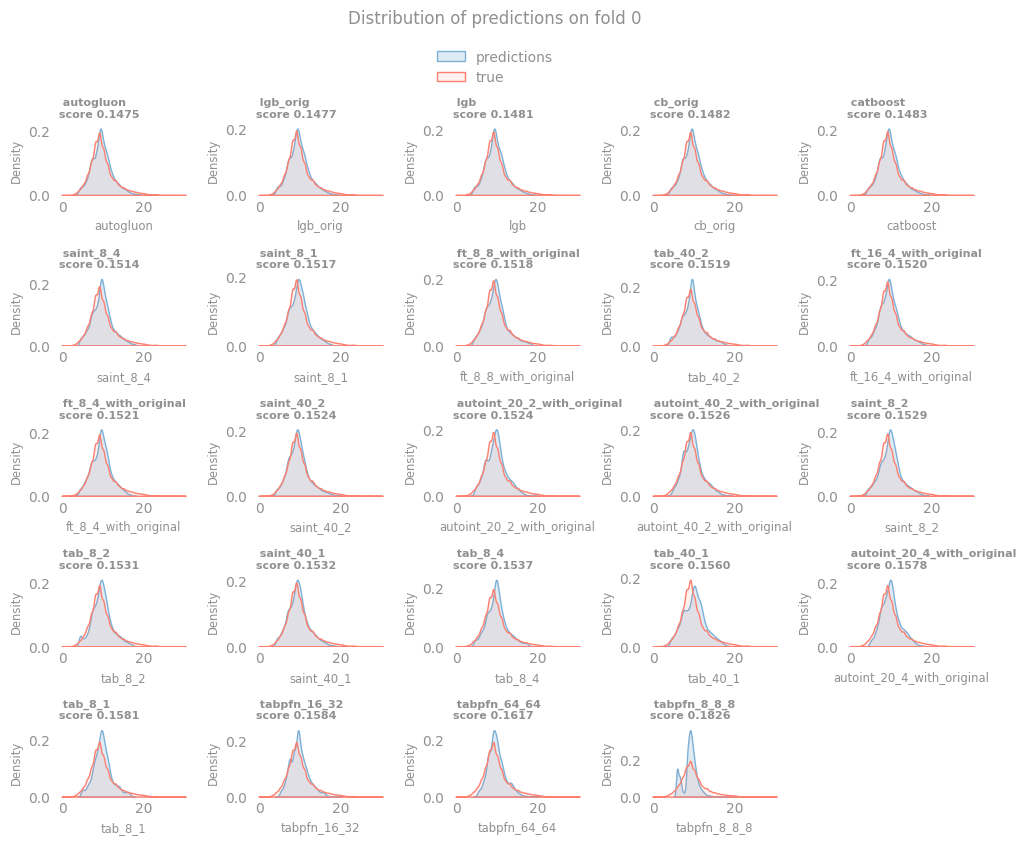

In [10]:
n_cols = 5
n_plots = df_stats.shape[0]
fig, axes = plt.subplots(ncols=n_cols, nrows=int(np.ceil(n_plots / n_cols)), figsize=(10, 8))
axes = axes.ravel()

for i, ax in zip(range(n_plots), axes):
    label = df_stats.iloc[i].name
    score = df_stats.iloc[i]['score']
    sns.kdeplot(df_preds[label], fill=True, ax=ax, label='predictions')
    sns.kdeplot(gt, ax=ax, alpha=0.1, fill=True, label='true')
    ax.set_title(f'  {label}\n score {score:.4f}', fontsize=8)

for ax in axes[n_plots:]:
    ax.set_xticklabels('')
    ax.set_yticklabels('')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ['predictions', 'true'], loc='upper center', bbox_to_anchor=(0.5, 1.015), bbox_transform=plt.gcf().transFigure)

plt.suptitle('Distribution of predictions on fold 0', y=1.05)

plt.tight_layout()
plt.show()

# Blend NN predictions 

In [11]:
gt = np.expm1(val_target)

ensembler = LinearRegression(positive=True)

ensembler.fit(np.log1p(df_nn_preds), val_target)
ens_oof = np.expm1(ensembler.predict(np.log1p(df_nn_preds)) )

display(pd.DataFrame(ensembler.coef_, index=df_nn_preds.columns, columns=['LR weights']))
print(f'{TXT_ACC} Score ensemble {TXT_RESET}    {rmsle(gt, ens_oof):.4f}')

,LR weights
saint_8_1,0.0000
saint_8_2,0.0000
saint_8_4,0.3788
saint_40_1,0.0000
saint_40_2,0.0000
tabpfn_16_32,0.0000
tabpfn_8_8_8,0.0000
tabpfn_64_64,0.1910
tab_8_1,0.0000
tab_8_2,0.0000


 Score ensemble     0.1508


# Blend lgb, catboost and NN models

In [16]:
gt = np.expm1(val_target)

ensembler = LinearRegression(positive=True)

df = np.log1p(df_preds.drop(['autogluon', 'catboost', 'lgb'], axis=1)
# [['lgb_orig', 'cb_orig', 
# 'saint_8_4'
# ]]
)
# df = np.log1p(df_preds.drop('autogluon', axis=1))
ensembler.fit(df, val_target)
ens_oof = np.expm1( ensembler.predict(df) )

display(pd.DataFrame(ensembler.coef_, index=df.columns, columns=['LR weights']))
print(f'{TXT_ACC} Score ensemble {TXT_RESET}    {rmsle(gt, ens_oof):.4f}')

,LR weights
saint_8_1,0.0000
saint_8_2,0.0000
saint_8_4,0.0000
saint_40_1,0.0000
saint_40_2,0.0000
tabpfn_16_32,0.0000
tabpfn_8_8_8,0.0000
tabpfn_64_64,0.0020
tab_8_1,0.0000
tab_8_2,0.0000


 Score ensemble     0.1474


# Round unanimous predictions
Summary: no gain in score

In [13]:
stds = df_preds.std(axis=1)
stds.max(), stds.min(), stds.mean()

(4.19051561050482, 0.11815025945088747, 0.3438976490628103)

In [14]:
preds_proc = df_preds['autogluon'].copy()
preds_proc = np.where((stds < 0.1) & (abs(preds_proc - np.round(preds_proc)) < 0.2), np.round(preds_proc), preds_proc)
new_col = pd.Series(preds_proc) 
rmsle(gt, df_preds['autogluon']), rmsle(gt, new_col)

(0.14754324336467878, 0.14754324336467878)